In [ ]:
% pip install numpy>=1.18.0
% pip install pandas==1.1.0
% pip install opencv-python==4.4.0.46
% pip install rasterio[s3]==1.1.8
% pip install awscli
% pip install geopandas

     |████████████████████████████████| 10.5MB 20.6MB/s 
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


     |████████████████████████████████| 49.5MB 62kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 18.3MB 1.2MB/s 
     |████████████████████████████████| 133kB 55.1MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 7.5MB 35.8MB/s 
     |████████████████████████████████| 153kB 54.6MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
     |████████████████████████

In [ ]:
import os
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [ ]:
import ast
import itertools
import math
from collections.abc import Iterable
from pathlib import Path
from typing import Dict
from typing import Tuple, List, Sequence
from urllib.parse import urlparse

import boto3
import botocore
import cv2
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
from rasterio.io import DatasetReader
from tqdm import tqdm
import matplotlib.pyplot as plt

## Utility Functions & Classes

In [ ]:
def read_image(image_path: str or Path) -> np.ndarray:
    """
    Reads an image and returns it.
    Args:
        image_path: the path of the image
    Returns:
        array of image
    """
    image_path = image_path if isinstance(image_path, str) else str(image_path)
    image = cv2.imread(image_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

    if image is None:
        raise ValueError(f'Failed to read image from {image_path} path.')

    return image


In [ ]:
def save_image(image: np.ndarray, image_path: str or Path, image_band: str = None) -> str:
    """
    Saves image and returns True in case of successful saving.
    Args:
        image: the image array to save
        image_path: the path of the image
        image_band: the image band name, which will be used in case of various color conversions
    Returns:
        image_path if image is successfully saved
    Raises:
        ValueError if the image is not saved
    """
    image_path = image_path if isinstance(image_path, str) else str(image_path)

    if image_band == 'RGB':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    try:
        check = cv2.imwrite(image_path, image)
    except Exception as e:
        raise ValueError(f'Failed to save image in {image_path} path due to error:\n {e}.')
    else:
        if check:
            return image_path
        else:
            ValueError(f'Failed to save image in {image_path} path.')



In [ ]:
def crop_image(image: np.ndarray, crop_area: Tuple[int, int, int, int]) -> np.ndarray:
    """
    Crops an are of image using its (top, left, bottom, right) coordinates.
    Args:
        image: 2D or 3D image, with shapes (H, W) or (H, W, C)
        crop_area: (top, left, bottom, right) coordinates of area

    Returns:
        cropped image array
    """
    top, left, bottom, right = crop_area
    if image.ndim == 2:
        return image[top:bottom, left:right]
    elif image.ndim == 3:
        return image[top:bottom, left:right, :]
    else:
        raise ValueError(f'The input image must be 2D or 3D, got: {image.shape}')


In [ ]:
def resize_image(image: np.ndarray, size: Tuple[int, int], algorithm=cv2.INTER_CUBIC):
    """
    Args:
        image: the image to resize
        size: the size of the new image - (H, W)
        algorithm: the algorithm used for resizing the image

                    Possible algorithms are:
                      INTER_NEAREST      = 0 - nearest neighbor interpolation
                      INTER_LINEAR       = 1 - bilinear interpolation
                      INTER_CUBIC        = 2 - bicubic interpolation
                      INTER_AREA         = 3 - resampling using pixel area relation
                      INTER_LANCZOS4     = 4 - Lanczos interpolation over 8x8 neighborhood
                      INTER_LINEAR_EXACT = 5 - Bit exact bilinear interpolation
    Returns:
        resized image array
    """
    # if size is None or equal to current size then return the original image
    if size is None or size == image.shape[:2]:
        return image

    # openCV takes fx=W and fy=H
    resized = cv2.resize(image, tuple(reversed(size)), interpolation=algorithm)

    # openCV losses single channel images 3rd dimension
    if image.ndim == 3 and resized.ndim != 3:
        resized = np.expand_dims(resized, axis=2)

    return resized


In [ ]:
class Slider:
    """Special class for sliding images, aka creatint tiles or patches."""

    def __init__(self,
                 window: int or Tuple[int, int],
                 stride: int or Tuple[int, int],
                 scales: float or Iterable[float] = (1.0,), ):
        """
        Args:
            window: int or (int, int), (h, w) the window size,
            stride: int or (int, int), (dh, dw) the strides,
            scales: (float ...), the scales to resize the original image
                    <1: downscale the original image
                    >1: upscale
        """
        if isinstance(window, int):
            self.window = (window, window)
        elif isinstance(window, tuple):
            self.window = window
        else:
            raise TypeError(f'window must be tuple or int, got {type(window)}')

        if isinstance(stride, int):
            self.stride = (stride, stride)
        elif isinstance(stride, tuple):
            self.stride = stride
        else:
            raise TypeError(f'stride must be tuple or int, got: {type(stride)}')

        if isinstance(scales, (float, int)):
            self.scales = (scales,)
        elif isinstance(scales, Iterable):
            self.scales = scales
        else:
            raise TypeError(f'scales must be iterable or float or int, got: {type(scales)}')

    def get_number_of_patches(self, input_h: int, input_w: int) -> int:
        """For given input sizes returns the possible number of sliding operations or the number of patches."""
        n_vertical = math.ceil((input_h - self.window[0]) / self.stride[0]) + 1
        n_horizontal = math.ceil((input_w - self.window[1]) / self.stride[1]) + 1
        n_scales = sum(1 for _ in self.scales)
        return n_horizontal * n_vertical * n_scales

    @staticmethod
    def apply_scale(scale: float, h: int, w: int) -> Tuple[int, int]:
        """Applies scaling."""
        return int(h / scale), int(w / scale)

    @staticmethod
    def get_1d_offset(current_position: int, step: int, original_size: int) -> Tuple[int, int]:
        """Returns the 1d offset coordinates as a result of one step from given position.
        If the potential window size exceed the original image size for instance,
        window_h > image_h, window_h will thrink to image_h. """
        if current_position == 0 and step > original_size:
            offset = (0, original_size)
        elif current_position + step > original_size:
            offset = (original_size - step, original_size)
        else:
            offset = (current_position, current_position + step)
        return offset

    def get_offsets(self, input_h: int, input_w: int) -> List[Tuple[int, int, int, int]]:
        """
        Returns the offsets: (top, left, bottom, right) to get sub-images as a result of sliding.
        Args:
            input_h: input image height
            input_w: input image width
        Returns:
            list of tuples where each tuple contains the patches or sub-images coordinates: (top, left, bottom, right)
        """
        all_offsets = []
        for s in self.scales:
            window_h, window_w = self.apply_scale(s, *self.window)
            stride_h, stride_w = self.apply_scale(s, *self.stride)
            hs = [self.get_1d_offset(h, window_h, input_h) for h in range(0, input_h - window_h + stride_h, stride_h)]
            ws = [self.get_1d_offset(w, window_w, input_w) for w in range(0, input_w - window_w + stride_w, stride_w)]
            all_offsets += list(itertools.product(hs, ws))

        return [(x[0][0], x[1][0], x[0][1], x[1][1]) for x in all_offsets]

    def get_patch(self, image: np.ndarray, offset: Tuple[int, int, int, int]):
        """
        Args:
            image: original image to extract patch, which must have the shape H x W x C
            offset: the tuples(top, left, bottom, right)
        Returns:
            image patch or sub-image window_h x window_h x C
        """
        return resize_image(crop_image(image, offset), self.window, algorithm=cv2.INTER_CUBIC)

    def get_patches(self, image: np.ndarray, offsets: List[Tuple[int, int, int, int]]):
        """
        Args:
            image: original image to extract patches, which must have the shape H x W x C
            offsets: the list of tuples (top, left, bottom, right)
        Returns:
            image patches concatenated in one array with shape: N x window_h x window_h x C,
            where N = len(offsets)
        """
        return np.stack(tuple(self.get_patch(image, offset) for offset in offsets))

    @staticmethod
    def reconstruct(patches: Sequence[np.ndarray],
                    offsets: List[Tuple[int, int, int, int]],
                    output_shape: Tuple[int, int, int] or Tuple[int, int]):
        """
        Recovers the image using its patches and their coordinates. Assumes that patches may
        overlap. Overlapped patches are averaged.
        Args:
            patches: the list of image patches
            offsets: the list of offsets (patch coordinates (top, left, bottom, right))
            output_shape: the shape of the output image (H, W, C) or (H, W)
        Returns:
            the array of output image with shape = output shape
        """

        if len(patches) != len(offsets):
            raise ValueError('Number of patches must be equal to number of offsets.')

        out_image, counter = np.zeros(output_shape), np.zeros(output_shape, dtype=np.float32)
        for offset, patch in zip(offsets, patches):
            top, left, bottom, right = offset
            out_image[top:bottom, left:right] += patch
            counter[top:bottom, left:right] += 1.

        out_image /= counter
        return out_image



## Data Download

In [ ]:
class FlightObject:
    """Special class for preparing data using flight id and field id."""

    BANDS = ('rgb', 'mask')

    def __init__(self, flight_id: str, field_id: str, download_folder: str):
        """

        Args:
            flight_id: the unique id of the flight
            field_id: the unique id of the field
            download_folder: the folder path where the flight data is downloaded
        """
        paths = self.get_image_paths_from_flight_code(flight_id, download_folder)
        self._download_folder = download_folder
        self._border_file_path = paths.pop('border_file_path')
        self._image_paths = {k.replace('_path', ''): v for k, v in paths.items()}

        self._flight_id = flight_id
        self._field_id = field_id
        self._output_depth = 'uint16'

        self._base_name = f"{self._field_id}_{self._flight_id}"
        self._crop_coordinates = None
        self._mask = None

    @staticmethod
    def get_image_paths_from_flight_code(flight_code: str, download_folder: str) -> Dict[str, str]:
        """Returns r, g, b and boarder file paths based on flight code."""
        return {
            'red_path': f'{download_folder}/{flight_code}/reflectance_red-red.tif',
            'green_path': f'{download_folder}/{flight_code}/reflectance_green-green.tif',
            'blue_path': f'{download_folder}/{flight_code}/reflectance_blue-blue.tif',
            'border_file_path': f'{download_folder}/{flight_code}/boundary.zip'
        }

    @property
    def image_paths(self) -> Dict[str, str]:
        """Returns images paths in S3."""
        return self._image_paths.copy()

    @property
    def border_file_path(self) -> str:
        """Returns images paths in S3."""
        return self._border_file_path

    @staticmethod
    def read_single_channel_raster_image(image_path: str,
                                         get_dataset: bool, ) -> np.ndarray or Tuple[np.ndarray, DatasetReader]:
        """Reads single channel raster image"""
        with rasterio.open(image_path) as src:
            image = np.nan_to_num(np.squeeze(src.read()), nan=0, posinf=0, neginf=0).astype(np.uint16)
        return (image, src) if get_dataset else image

    @staticmethod
    def get_border_mask(border_file_path, raster_dataset: DatasetReader) -> np.ndarray:
        """Returns boolean mask, where True means that pixel belongs to the field, aka inside the border geometry."""
        gdf = gpd.read_file(border_file_path)
        if gdf.shape[0] != 1 or 'geometry' not in gdf.columns:
            raise ValueError(f'Boundary file {border_file_path} is wrong.')

        border_geometry = gdf.to_crs(crs=raster_dataset.crs)['geometry'].iloc[0]
        mask, _, _ = rasterio.mask.raster_geometry_mask(raster_dataset, [border_geometry], crop=False, invert=True)
        return mask

    def get_mask(self) -> np.ndarray:
        """Returns boolean Border Mask."""
        red_image, red_raster_dataset = self.read_single_channel_raster_image(
            self._image_paths['red'], True
        )

        border_mask = self.get_border_mask(self._border_file_path, red_raster_dataset)
        border_mask = np.nan_to_num(border_mask, nan=0, posinf=0, neginf=0)

        x_index, y_index = np.nonzero(border_mask)
        self._crop_coordinates = (x_index.min(), y_index.min(), x_index.max(), y_index.max())
        self._mask = crop_image(border_mask, self._crop_coordinates).astype(np.uint8)

        return self._mask.copy()

    def get_rgb(self) -> np.ndarray:
        """Returns RGB image as uint8 or unit16."""
        rgb_image = np.stack(
            [
                self.read_single_channel_raster_image(self._image_paths[c], False)
                for c in ('red', 'green', 'blue')
            ],
            axis=2
        )
        return crop_image(rgb_image, self._crop_coordinates)

    def get_images(self) -> Dict[str, np.ndarray]:
        """Returns all images."""
        mask = self.get_mask()
        rgb = self.get_rgb()
        rgb *= mask[..., np.newaxis]
        return {'rgb': rgb, 'mask': mask}

    def create_tiles(self, output_folder: Path, slider_config: Dict) -> List[str]:
        """
        Scales images by given scale factor, creates patches and saves them in output folder.
        Args:
            output_folder: the folder where the patched images will be saved
            slider_config: the config creating patches (tiles)
        """
        factor = 2**14
        rgb = self.get_images()['rgb']
        rgb = np.clip((rgb / factor) * 255,0, 255)
        slider = Slider(**slider_config)
        offsets = slider.get_offsets(*rgb.shape[:2])

        tile_paths = []
        for i, offset in enumerate(offsets):
            tile = slider.get_patch(rgb, offset)
            band_image_name = f'{self._base_name}_rgb_{i}-patch.png'
            check = np.all(tile == 0)
            if check:
                print(f'{self._flight_id}-{self._field_id}: patch_number={i} have been skipped.')
            else:
                output_path = output_folder.joinpath(band_image_name)
                output_path.parent.mkdir(exist_ok=True, parents=True)
                tile_paths.append(save_image(tile, output_path, image_band='rgb'))
        print(f'{self._base_name}: n={len(tile_paths)} patches have been saved, original size={rgb.shape}.')
        return tile_paths


In [ ]:
class DatasetCreator:
    """Special Class for downloading images from S3 and splitting them into small tiles."""

    def __init__(self, s3_uri: str, download_folder: str, output_folder: str, tile_size: int = 512):
        """

        Args:
            s3_uri: the  S3 URI - path of the images in S3
            download_folder: the folder to store raw images
            output_folder: the folder to store tiles (aka, small images with equal sizes)
            tile_size: the size of tiles, default: 512
        """

        self.download_folder = Path(download_folder)
        self.output_folder = Path(output_folder)

        self.download_folder.mkdir(parents=True, exist_ok=True)
        self.output_folder.mkdir(parents=True, exist_ok=True)

        parsed_uri = urlparse(s3_uri, allow_fragments=False)
        self.s3_uri = s3_uri
        self.s3_bucket = parsed_uri.netloc
        self.s3_folder = parsed_uri.path.lstrip('/')

        self.tile_size = tile_size

    @staticmethod
    def download_s3_dir(bucket: str, folder_path: str, download_folder: Path):
        """Downloads s3 directory to download folder."""
        client = boto3.client('s3')
        client.meta.events.register('choose-signer.s3.*', botocore.handlers.disable_signing)

        # Handle missing / at end of prefix
        if not folder_path.endswith('/'):
            folder_path += '/'

        paginator = client.get_paginator('list_objects_v2')
        for result in paginator.paginate(Bucket=bucket, Prefix=folder_path):
            # Download each file individually
            for key in tqdm(result['Contents'], total=len(result['Contents'])):
                # Calculate relative path
                rel_path = key['Key'][len(folder_path):]
                # Skip paths ending in /
                if not key['Key'].endswith('/'):
                    local_file_path = download_folder.joinpath(rel_path)
                    local_file_path.parents[0].mkdir(parents=True, exist_ok=True)
                    # Skip download if already downloaded
                    if not local_file_path.exists():
                        client.download_file(bucket, key['Key'], str(local_file_path))

    def download_data(self):
        """Downloads data from S3."""
        self.download_s3_dir(self.s3_bucket, self.s3_folder, self.download_folder)
        df = pd.read_csv(self.download_folder.joinpath('final_data.CSV'))
        df['paths'] = df['paths'].apply(ast.literal_eval)
        df['local_paths'] = df['paths'].apply(
            lambda x: {k: v.replace(self.s3_uri, str(self.download_folder)) for k, v in x.items()}
        )
        return df

    def create_tiles(self, df: pd.DataFrame) -> pd.DataFrame:
        """Creates tiles from downloaded images."""
        slider_config = {'window': self.tile_size, 'stride': self.tile_size, 'scales': (1,)}

        final_df = []
        for _, row in tqdm(df.iterrows(), total=len(df)):
            flight_obj = FlightObject(row['flight_code'], row['field_token'], self.download_folder)
            tiles_paths = flight_obj.create_tiles(self.output_folder, slider_config)
            for i, tile_path in enumerate(tiles_paths):
                final_df.append(
                    {
                        'flight_code': row['flight_code'],
                        'field_token': row['field_token'],
                        'class': row['ActualStatus'],
                        'flight_date': row['flight_date'],
                        'flight_number': row['flight_number'],
                        'tile_number': i,
                        'image_path': tile_path,
                    }
                )
        final_df = pd.DataFrame(final_df)
        final_df['class'] = final_df['class'].isin(('Planted', 'Emerged'))

        return final_df

    def prepare_data(self):
        """Downloads data, creates tiles and saves them in output folder."""
        df = self.download_data()
        tiles_df = self.create_tiles(df)
        tiles_df.to_csv(self.output_folder.joinpath('tiles.CSV'), index=False)
        return tiles_df


In [ ]:
S3_URI = 's3://intelinair-internship/field_state_classification/'
DOWNLOAD_FOLDER = '/content/image_data'
OUTPUT_FOLDER = '/content/final_image_data'
TILE_SIZE = 224

In [ ]:
creator = DatasetCreator(S3_URI, DOWNLOAD_FOLDER, OUTPUT_FOLDER, tile_size=224)

In [ ]:
df = creator.prepare_data()

  0%|          | 0/30 [00:00<?, ?it/s]

1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=0 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=1 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=2 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=15 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=16 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=17 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=18 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=19 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=34 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=35 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=36 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=53 have been skipped.


  3%|▎         | 1/30 [00:10<04:51, 10.05s/it]

1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=270 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=288 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=289 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=305 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=306 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=307 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=308 have been skipped.
1TJZT39WQ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=323 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_1TJZT39WQ: n=304 patches have been saved, original size=(3999, 4016, 3).


  7%|▋         | 2/30 [00:26<05:38, 12.09s/it]

2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=508 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=509 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=510 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=511 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=512 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=513 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=520 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=521 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=522 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=523 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=524 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=525 have been s

 10%|█         | 3/30 [00:38<05:18, 11.81s/it]

3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=344 have been skipped.
3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=345 have been skipped.
3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=346 have been skipped.
3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=347 have been skipped.
3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=348 have been skipped.
3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=349 have been skipped.
3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=354 have been skipped.
3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=355 have been skipped.
3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=356 have been skipped.
3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=357 have been skipped.
3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=358 have been skipped.
3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=359 have been s

 13%|█▎        | 4/30 [00:48<04:56, 11.41s/it]

42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=344 have been skipped.
42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=345 have been skipped.
42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=346 have been skipped.
42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=347 have been skipped.
42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=348 have been skipped.
42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=349 have been skipped.
42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=354 have been skipped.
42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=355 have been skipped.
42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=356 have been skipped.
42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=357 have been skipped.
42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=358 have been skipped.
42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=359 have been s

 17%|█▋        | 5/30 [01:00<04:49, 11.56s/it]

E83UE8JT4-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=460 have been skipped.
E83UE8JT4-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=461 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_E83UE8JT4: n=428 patches have been saved, original size=(4708, 4541, 3).


 20%|██        | 6/30 [01:11<04:31, 11.32s/it]

EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=344 have been skipped.
EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=345 have been skipped.
EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=346 have been skipped.
EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=347 have been skipped.
EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=348 have been skipped.
EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=349 have been skipped.
EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=354 have been skipped.
EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=355 have been skipped.
EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=356 have been skipped.
EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=357 have been skipped.
EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=358 have been skipped.
EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=359 have been s

 23%|██▎       | 7/30 [01:21<04:12, 10.99s/it]

EVTQTDFEJ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=340 have been skipped.
EVTQTDFEJ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=360 have been skipped.
EVTQTDFEJ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=361 have been skipped.
EVTQTDFEJ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=378 have been skipped.
EVTQTDFEJ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=379 have been skipped.
EVTQTDFEJ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=380 have been skipped.
EVTQTDFEJ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=381 have been skipped.
EVTQTDFEJ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=382 have been skipped.
EVTQTDFEJ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=398 have been skipped.
EVTQTDFEJ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=399 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_EVTQTDFEJ: n=375 patches have been saved, original size=(4451, 4291, 3).
F98U2YA3K-b7add13d-8802-46cb-8d3f-cb1ce7daf029: pa

 27%|██▋       | 8/30 [01:30<03:51, 10.53s/it]

F98U2YA3K-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=270 have been skipped.
F98U2YA3K-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=288 have been skipped.
F98U2YA3K-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=289 have been skipped.
F98U2YA3K-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=305 have been skipped.
F98U2YA3K-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=306 have been skipped.
F98U2YA3K-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=307 have been skipped.
F98U2YA3K-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=308 have been skipped.
F98U2YA3K-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=323 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_F98U2YA3K: n=304 patches have been saved, original size=(3999, 4016, 3).
FPG2L7UTK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=0 have been skipped.
FPG2L7UTK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=1 have been skipped.
FPG2L7UTK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_

 30%|███       | 9/30 [01:39<03:30, 10.00s/it]

FPG2L7UTK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=270 have been skipped.
FPG2L7UTK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=288 have been skipped.
FPG2L7UTK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=289 have been skipped.
FPG2L7UTK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=305 have been skipped.
FPG2L7UTK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=306 have been skipped.
FPG2L7UTK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=307 have been skipped.
FPG2L7UTK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=308 have been skipped.
FPG2L7UTK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=323 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_FPG2L7UTK: n=304 patches have been saved, original size=(3999, 4016, 3).


 33%|███▎      | 10/30 [01:50<03:23, 10.15s/it]

FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=344 have been skipped.
FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=345 have been skipped.
FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=346 have been skipped.
FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=347 have been skipped.
FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=348 have been skipped.
FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=349 have been skipped.
FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=354 have been skipped.
FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=355 have been skipped.
FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=356 have been skipped.
FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=357 have been skipped.
FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=358 have been skipped.
FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=359 have been s

 37%|███▋      | 11/30 [01:59<03:06,  9.82s/it]

FYXD9U983-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=270 have been skipped.
FYXD9U983-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=288 have been skipped.
FYXD9U983-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=289 have been skipped.
FYXD9U983-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=305 have been skipped.
FYXD9U983-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=306 have been skipped.
FYXD9U983-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=307 have been skipped.
FYXD9U983-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=308 have been skipped.
FYXD9U983-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=323 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_FYXD9U983: n=304 patches have been saved, original size=(3999, 4016, 3).


 40%|████      | 12/30 [02:14<03:26, 11.50s/it]

GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=508 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=509 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=510 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=511 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=512 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=513 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=514 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=515 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=516 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=520 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=521 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=522 have been s

 43%|████▎     | 13/30 [02:24<03:08, 11.08s/it]

GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=344 have been skipped.
GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=345 have been skipped.
GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=346 have been skipped.
GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=347 have been skipped.
GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=348 have been skipped.
GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=349 have been skipped.
GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=354 have been skipped.
GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=355 have been skipped.
GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=356 have been skipped.
GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=357 have been skipped.
GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=358 have been skipped.
GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=359 have been s

 47%|████▋     | 14/30 [02:33<02:47, 10.47s/it]

GWWIAV2VV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=270 have been skipped.
GWWIAV2VV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=288 have been skipped.
GWWIAV2VV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=289 have been skipped.
GWWIAV2VV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=305 have been skipped.
GWWIAV2VV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=306 have been skipped.
GWWIAV2VV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=307 have been skipped.
GWWIAV2VV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=308 have been skipped.
GWWIAV2VV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=323 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_GWWIAV2VV: n=304 patches have been saved, original size=(3999, 4016, 3).


 50%|█████     | 15/30 [02:44<02:38, 10.55s/it]

J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=344 have been skipped.
J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=345 have been skipped.
J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=346 have been skipped.
J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=347 have been skipped.
J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=348 have been skipped.
J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=349 have been skipped.
J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=354 have been skipped.
J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=355 have been skipped.
J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=356 have been skipped.
J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=357 have been skipped.
J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=358 have been skipped.
J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=359 have been s

 53%|█████▎    | 16/30 [02:54<02:26, 10.47s/it]

KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=344 have been skipped.
KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=345 have been skipped.
KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=346 have been skipped.
KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=347 have been skipped.
KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=348 have been skipped.
KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=349 have been skipped.
KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=354 have been skipped.
KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=355 have been skipped.
KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=356 have been skipped.
KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=357 have been skipped.
KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=358 have been skipped.
KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=359 have been s

 57%|█████▋    | 17/30 [03:04<02:12, 10.20s/it]

KR4TV4KAT-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=270 have been skipped.
KR4TV4KAT-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=288 have been skipped.
KR4TV4KAT-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=289 have been skipped.
KR4TV4KAT-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=305 have been skipped.
KR4TV4KAT-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=306 have been skipped.
KR4TV4KAT-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=307 have been skipped.
KR4TV4KAT-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=308 have been skipped.
KR4TV4KAT-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=323 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_KR4TV4KAT: n=304 patches have been saved, original size=(3999, 4016, 3).


 60%|██████    | 18/30 [03:11<01:53,  9.42s/it]

M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=344 have been skipped.
M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=345 have been skipped.
M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=346 have been skipped.
M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=347 have been skipped.
M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=348 have been skipped.
M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=349 have been skipped.
M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=354 have been skipped.
M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=355 have been skipped.
M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=356 have been skipped.
M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=357 have been skipped.
M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=358 have been skipped.
M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=359 have been s

 63%|██████▎   | 19/30 [03:20<01:41,  9.21s/it]

N7W26YIGK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=270 have been skipped.
N7W26YIGK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=288 have been skipped.
N7W26YIGK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=289 have been skipped.
N7W26YIGK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=305 have been skipped.
N7W26YIGK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=306 have been skipped.
N7W26YIGK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=307 have been skipped.
N7W26YIGK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=308 have been skipped.
N7W26YIGK-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=323 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_N7W26YIGK: n=304 patches have been saved, original size=(3999, 4016, 3).
N9WCYFDNV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=0 have been skipped.
N9WCYFDNV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=1 have been skipped.
N9WCYFDNV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_

 67%|██████▋   | 20/30 [03:29<01:31,  9.14s/it]

N9WCYFDNV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=270 have been skipped.
N9WCYFDNV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=288 have been skipped.
N9WCYFDNV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=289 have been skipped.
N9WCYFDNV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=305 have been skipped.
N9WCYFDNV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=306 have been skipped.
N9WCYFDNV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=307 have been skipped.
N9WCYFDNV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=308 have been skipped.
N9WCYFDNV-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=323 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_N9WCYFDNV: n=304 patches have been saved, original size=(3999, 4016, 3).


 70%|███████   | 21/30 [03:40<01:25,  9.53s/it]

NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=344 have been skipped.
NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=345 have been skipped.
NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=346 have been skipped.
NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=347 have been skipped.
NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=348 have been skipped.
NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=349 have been skipped.
NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=354 have been skipped.
NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=355 have been skipped.
NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=356 have been skipped.
NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=357 have been skipped.
NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=358 have been skipped.
NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=359 have been s

 73%|███████▎  | 22/30 [03:50<01:19,  9.93s/it]

P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=344 have been skipped.
P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=345 have been skipped.
P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=346 have been skipped.
P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=347 have been skipped.
P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=348 have been skipped.
P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=349 have been skipped.
P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=354 have been skipped.
P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=355 have been skipped.
P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=356 have been skipped.
P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=357 have been skipped.
P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=358 have been skipped.
P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=359 have been s

 77%|███████▋  | 23/30 [03:59<01:07,  9.63s/it]

Q9ALKK7XZ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=270 have been skipped.
Q9ALKK7XZ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=288 have been skipped.
Q9ALKK7XZ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=289 have been skipped.
Q9ALKK7XZ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=305 have been skipped.
Q9ALKK7XZ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=306 have been skipped.
Q9ALKK7XZ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=307 have been skipped.
Q9ALKK7XZ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=308 have been skipped.
Q9ALKK7XZ-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=323 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_Q9ALKK7XZ: n=304 patches have been saved, original size=(3999, 4016, 3).
UI4P3E22W-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=0 have been skipped.
UI4P3E22W-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=1 have been skipped.
UI4P3E22W-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_

 80%|████████  | 24/30 [04:08<00:56,  9.43s/it]

UI4P3E22W-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=270 have been skipped.
UI4P3E22W-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=288 have been skipped.
UI4P3E22W-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=289 have been skipped.
UI4P3E22W-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=305 have been skipped.
UI4P3E22W-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=306 have been skipped.
UI4P3E22W-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=307 have been skipped.
UI4P3E22W-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=308 have been skipped.
UI4P3E22W-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=323 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_UI4P3E22W: n=304 patches have been saved, original size=(3999, 4016, 3).


 83%|████████▎ | 25/30 [04:19<00:49,  9.83s/it]

VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=344 have been skipped.
VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=345 have been skipped.
VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=346 have been skipped.
VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=347 have been skipped.
VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=348 have been skipped.
VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=349 have been skipped.
VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=354 have been skipped.
VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=355 have been skipped.
VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=356 have been skipped.
VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=357 have been skipped.
VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=358 have been skipped.
VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=359 have been s

 87%|████████▋ | 26/30 [04:30<00:40, 10.16s/it]

VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=344 have been skipped.
VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=345 have been skipped.
VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=346 have been skipped.
VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=347 have been skipped.
VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=348 have been skipped.
VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=349 have been skipped.
VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=354 have been skipped.
VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=355 have been skipped.
VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=356 have been skipped.
VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=357 have been skipped.
VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=358 have been skipped.
VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=359 have been s

 90%|█████████ | 27/30 [04:42<00:32, 10.74s/it]

W7AADUXTW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=460 have been skipped.
W7AADUXTW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=461 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_W7AADUXTW: n=428 patches have been saved, original size=(4708, 4541, 3).
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=0 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=1 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=2 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=15 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=16 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=17 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=18 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=19 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=

 93%|█████████▎| 28/30 [04:51<00:20, 10.09s/it]

YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=270 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=288 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=289 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=305 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=306 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=307 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=308 have been skipped.
YLTE7FRJW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=323 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_YLTE7FRJW: n=304 patches have been saved, original size=(3999, 4016, 3).
ZVDH6FY93-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=0 have been skipped.
ZVDH6FY93-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=1 have been skipped.
ZVDH6FY93-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_

 97%|█████████▋| 29/30 [05:00<00:09,  9.75s/it]

ZVDH6FY93-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=270 have been skipped.
ZVDH6FY93-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=288 have been skipped.
ZVDH6FY93-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=289 have been skipped.
ZVDH6FY93-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=305 have been skipped.
ZVDH6FY93-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=306 have been skipped.
ZVDH6FY93-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=307 have been skipped.
ZVDH6FY93-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=308 have been skipped.
ZVDH6FY93-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=323 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_ZVDH6FY93: n=304 patches have been saved, original size=(3999, 4016, 3).


100%|██████████| 30/30 [05:10<00:00, 10.34s/it]

ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=344 have been skipped.
ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=345 have been skipped.
ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=346 have been skipped.
ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=347 have been skipped.
ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=348 have been skipped.
ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=349 have been skipped.
ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=354 have been skipped.
ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=355 have been skipped.
ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=356 have been skipped.
ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=357 have been skipped.
ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=358 have been skipped.
ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=359 have been s

In [ ]:
df.to_csv('image_data_224.csv')

In [ ]:
from google.colab import files
files.download("/content/image_data_224.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown crop the images into (224,224) size and get 10437 images


In [ ]:
df.head()

,flight_code,field_token,class,flight_date,flight_number,tile_number,image_path
0,1TJZT39WQ,b7add13d-8802-46cb-8d3f-cb1ce7daf029,False,2020-07-11,9,0,/content/final_image_data/b7add13d-8802-46cb-8...
1,1TJZT39WQ,b7add13d-8802-46cb-8d3f-cb1ce7daf029,False,2020-07-11,9,1,/content/final_image_data/b7add13d-8802-46cb-8...
2,1TJZT39WQ,b7add13d-8802-46cb-8d3f-cb1ce7daf029,False,2020-07-11,9,2,/content/final_image_data/b7add13d-8802-46cb-8...
3,1TJZT39WQ,b7add13d-8802-46cb-8d3f-cb1ce7daf029,False,2020-07-11,9,3,/content/final_image_data/b7add13d-8802-46cb-8...
4,1TJZT39WQ,b7add13d-8802-46cb-8d3f-cb1ce7daf029,False,2020-07-11,9,4,/content/final_image_data/b7add13d-8802-46cb-8...


In [ ]:
df.shape

(10437, 7)

In [ ]:
# import pandas as pd
# df=pd.read_csv("/content/image_data_224.csv")

In [ ]:
#@markdown split the data into train/validation/test sets, such that each set contains full images

In [ ]:
# from sklearn.utils import shuffle
# flight_codes=list(set(df.flight_code))
# flight_codes=shuffle(flight_codes, random_state=42)
# train_ids = flight_codes[:20]
# val_ids = flight_codes[20:25]
# test_ids = flight_codes[25:]
# train_data=df[df['flight_code'].isin(train_ids)]
# val_data=df[df['flight_code'].isin(val_ids)]
# test_data=df[df['flight_code'].isin(test_ids)]


In [ ]:
# from sklearn.model_selection import train_test_split
# train_data, test_data, _, _,= train_test_split(df, df, test_size=0.15, random_state=42, shuffle=True)
# train_data, val_data, _, _,= train_test_split(train_data, train_data, test_size=0.15, random_state=42, shuffle=True)


In [ ]:
from sklearn.utils import shuffle
false_ids = list(set(df[df['class'] == False]['flight_code']))
false_ids = shuffle(false_ids)
train_ids=false_ids[:int(np.floor(len(false_ids)*0.7))]
val_ids=false_ids[int(np.floor(len(false_ids)*0.7)):(int(np.floor(len(false_ids)*0.7))+int(np.round(len(false_ids)*0.15,0)))]
test_ids=false_ids[(int(np.floor(len(false_ids)*0.7))+int(np.round(len(false_ids)*0.15,0))):]
true_ids = list(set(df[df['class'] == True]['flight_code']))
true_ids = shuffle(true_ids)
train_ids = train_ids + true_ids[:int(np.floor(len(true_ids)*0.7))]
val_ids= val_ids+true_ids[int(np.floor(len(true_ids)*0.7)):(int(np.floor(len(true_ids)*0.7))+int(np.round(len(true_ids)*0.15,0)))]
test_ids=test_ids + true_ids[(int(np.floor(len(true_ids)*0.7))+int(np.round(len(true_ids)*0.15,0))):]
train_data=df[df['flight_code'].isin(train_ids)]
val_data=df[df['flight_code'].isin(val_ids)]
test_data=df[df['flight_code'].isin(test_ids)]

In [ ]:
print({'train_data' : len(train_data),  
       'val_data' :   len(val_data),
       'test_data' : len(test_data)})

{'train_data': 7221, 'val_data': 1608, 'test_data': 1608}


In [ ]:

print({'train_classes' : train_data['class'].mean()})
print({'val_classes' : val_data['class'].mean()})
print({'test_classes' : test_data['class'].mean()})

{'train_classes': 0.3629691178507132}
{'val_classes': 0.4054726368159204}
{'test_classes': 0.4054726368159204}


The data is saved in '/content/final_image_data/' folder. You can find there also the "tiles.CSV" file which is the same dataframe in CSV format
Dataframe contains image paths which you should use during training and the label - 'class', which is a boolean column, so you have binary 
classfication problem.

In [ ]:
# equal observation for  two classes
train_data1=train_data[train_data['class']==True] 
train_data2=train_data[train_data['class']==False].iloc[:train_data1.shape[0],:]
train_data=pd.concat((train_data1, train_data2))

In [ ]:
train_data.shape

(5242, 8)

In [ ]:
#@markdown read images and get labels

In [ ]:
def input_creation(data):
  """function for reading images using images' patch from data frame` df  and combine them in an array."""
  X=[]
  Y=[]
  for i in range(len(data)):
    sample_image = read_image(data['image_path'].iloc[i])
    #sample_image = cv2.resize(sample_image, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
    sample_label = data['class'].iloc[i]
    X.append(sample_image)
    Y.append(sample_label)

  return np.array(X), np.array(Y)



In [ ]:
X_train, y_train = input_creation(train_data)
X_val, y_val = input_creation(val_data)
X_test, y_test = input_creation(test_data)


In [ ]:
X_train.shape, y_train.shape

((5242, 224, 224, 3), (5242,))

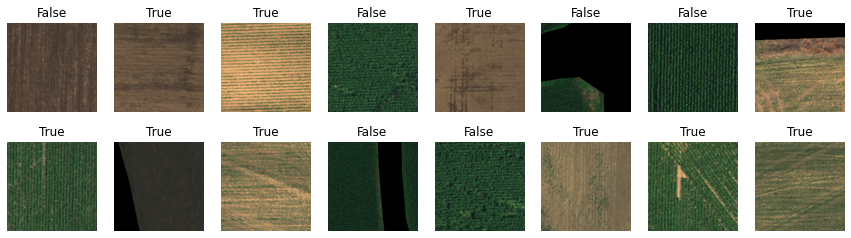

In [ ]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_train[random_index, :])
        ax.set_title(y_train[random_index])
plt.show()

In [ ]:

# import skimage
# from skimage.measure import block_reduce

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
#@markdown model architecture

In [ ]:
from keras.applications import vgg16
vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:

vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model=Sequential([Input(shape=(224,224,3)),
                  keras.layers.experimental.preprocessing.Rescaling(scale= 1 / 255.0)
])
for layer in vgg16_model.layers:
  layer.trainable=False
  model.add(layer)

In [ ]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     1

In [ ]:
opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)

In [ ]:
#@markdown model training process

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='auto', patience=5, restore_best_weights=True)
epochs=100
batch_size=32
history=model.fit(X_train, y_train,
              batch_size=batch_size,
          validation_data=(X_val, y_val),
          callbacks=[callback],
          epochs=epochs)

Epoch 1/100
164/164 [==============================] - 104s 391ms/step - loss: 0.3858 - accuracy: 0.8253 - val_loss: 1.2002 - val_accuracy: 0.6213
Epoch 2/100
164/164 [==============================] - 52s 317ms/step - loss: 0.2107 - accuracy: 0.9077 - val_loss: 0.7611 - val_accuracy: 0.7052
Epoch 3/100
164/164 [==============================] - 52s 317ms/step - loss: 0.1718 - accuracy: 0.9269 - val_loss: 1.8001 - val_accuracy: 0.5983
Epoch 4/100
164/164 [==============================] - 52s 316ms/step - loss: 0.1456 - accuracy: 0.9415 - val_loss: 1.4666 - val_accuracy: 0.6200
Epoch 5/100
164/164 [==============================] - 52s 316ms/step - loss: 0.1366 - accuracy: 0.9454 - val_loss: 1.2566 - val_accuracy: 0.6604
Epoch 6/100
164/164 [==============================] - 52s 316ms/step - loss: 0.1190 - accuracy: 0.9547 - val_loss: 0.9327 - val_accuracy: 0.7152
Epoch 7/100
164/164 [==============================] - 52s 317ms/step - loss: 0.1072 - accuracy: 0.9617 - val_loss: 1.1110 

In [ ]:
#@markdown model history

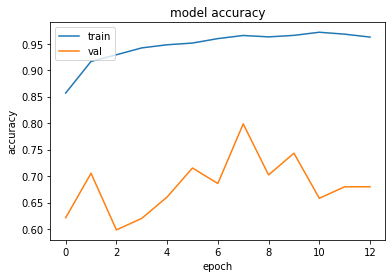

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

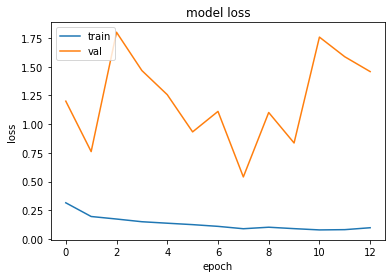

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_train, y_train)

164/164 [==============================] - 40s 241ms/step - loss: 0.0565 - accuracy: 0.9804


[0.05645975470542908, 0.9803510308265686]

In [ ]:
model.evaluate(X_val, y_val)

51/51 [==============================] - 12s 239ms/step - loss: 0.5405 - accuracy: 0.7985


[0.5405449271202087, 0.7985074520111084]

In [ ]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 12s 238ms/step - loss: 0.8463 - accuracy: 0.8172


[0.8463020920753479, 0.8171641826629639]

In [ ]:
#@markdown model evaluation: test set

In [ ]:
predictions=model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def plot_conf_matrix(cm, classes, normalize=True, title='confusion_matrix'):
  plt.imshow(cm , interpolation='nearest')
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=25)
  plt.yticks(tick_marks, classes)
  if normalize:
    cm=cm.astype('float32') / cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, np.round(cm[i,j], 2))
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")


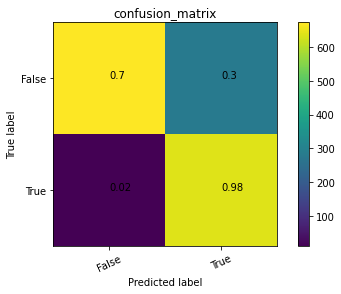

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, predictions)
cm_class=['False', "True"]
plot_conf_matrix(cm, cm_class, normalize=True)

In [ ]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, roc_auc_score, accuracy_score, roc_curve, auc
def evaluation_matrics(y_test, predictions):
  print({'accuracy for False class': accuracy_score(y_test[y_test==False], predictions[y_test==False].reshape(-1))})
  print({'accuracy for True class': accuracy_score(y_test[y_test==True], predictions[y_test==True].reshape(-1))})
  print({'accuracy ': accuracy_score(y_test, predictions.reshape(-1))})
  # precision 
  precision = precision_score(y_test, predictions)
  print('Precision: %f' % precision)
  # recall:
  recall = recall_score(y_test, predictions)
  print('Recall: %f' % recall)
  # f1 scorw:
  f1 = f1_score(y_test, predictions)
  print('F1 score: %f' % f1)

In [ ]:
evaluation_matrics(y_test, predictions)

{'accuracy for False class': 0.7039748953974896}
{'accuracy for True class': 0.9831288343558282}
{'accuracy ': 0.8171641791044776}
Precision: 0.693723
Recall: 0.983129
F1 score: 0.813452


In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.98      0.70      0.82       956
        True       0.69      0.98      0.81       652

    accuracy                           0.82      1608
   macro avg       0.84      0.84      0.82      1608
weighted avg       0.87      0.82      0.82      1608



In [ ]:
prediction_proba=model.predict_proba(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


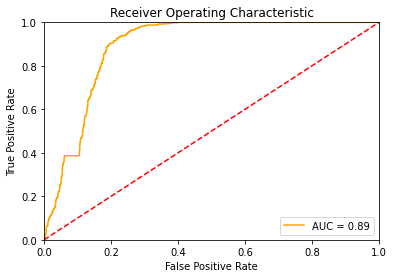

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, prediction_proba.reshape(-1))
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'orange', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
####There is an overfiting problem

In [ ]:
## use data augmentation

In [ ]:
from keras.applications import vgg16
vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling='max')

In [ ]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
  # layers.experimental.preprocessing.Rescaling(scale= 1 / 255.0),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.3),
  layers.experimental.preprocessing.RandomZoom(.3, .3)
])

In [ ]:
X_train=data_augmentation(X_train)

In [ ]:
X_train.shape

TensorShape([5242, 224, 224, 3])

In [ ]:
X_train=np.array(X_train)

In [ ]:
model1=Sequential([Input(shape=(224,224,3)),
                  keras.layers.experimental.preprocessing.Rescaling(scale= 1 / 255.0)
])
for layer in vgg16_model.layers:
  layer.trainable=False
  model1.add(layer)

In [ ]:
# model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
input_3 (InputLayer)         multiple                  0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)    

In [ ]:
opt = keras.optimizers.SGD(lr=0.01, momentum=0.99)

In [ ]:
#@markdown model training process

In [ ]:
model1.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='auto', patience=5, restore_best_weights=True)
epochs=100
batch_size=32
history=model1.fit(X_train, y_train,
              batch_size=batch_size,
          validation_data=(X_val, y_val),
          callbacks=[callback],
          epochs=epochs)

Epoch 1/100
164/164 [==============================] - 52s 317ms/step - loss: 0.3316 - accuracy: 0.8539 - val_loss: 0.4885 - val_accuracy: 0.7873
Epoch 2/100
164/164 [==============================] - 52s 316ms/step - loss: 0.3194 - accuracy: 0.8567 - val_loss: 0.6046 - val_accuracy: 0.7444
Epoch 3/100
164/164 [==============================] - 52s 316ms/step - loss: 0.3069 - accuracy: 0.8655 - val_loss: 0.8380 - val_accuracy: 0.7009
Epoch 4/100
164/164 [==============================] - 52s 316ms/step - loss: 0.3064 - accuracy: 0.8676 - val_loss: 0.5100 - val_accuracy: 0.7761
Epoch 5/100
164/164 [==============================] - 52s 316ms/step - loss: 0.3135 - accuracy: 0.8626 - val_loss: 0.6342 - val_accuracy: 0.7332
Epoch 6/100
164/164 [==============================] - 52s 315ms/step - loss: 0.3133 - accuracy: 0.8651 - val_loss: 0.4239 - val_accuracy: 0.8215
Epoch 7/100
164/164 [==============================] - 52s 315ms/step - loss: 0.2984 - accuracy: 0.8722 - val_loss: 0.4921 -

In [1]:
#@markdown model history

In [ ]:
model1.evaluate(X_train, y_train)
model1.evaluate(X_val, y_val)

51/51 [==============================] - 12s 238ms/step - loss: 0.4239 - accuracy: 0.8215


[0.42391693592071533, 0.8215174078941345]

In [ ]:
model1.evaluate(X_test, y_test)

51/51 [==============================] - 12s 238ms/step - loss: 0.4076 - accuracy: 0.8470


[0.40762579441070557, 0.8470149040222168]

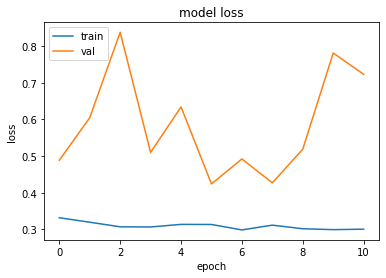

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

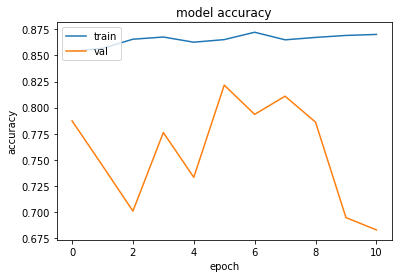

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#@markdown model evaluation: test set

In [ ]:
y_pred=model1.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


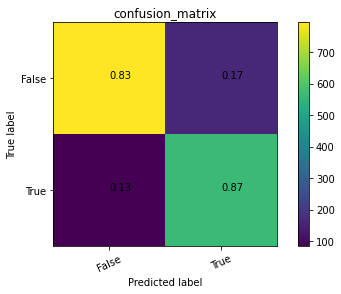

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
cm_class=['False', "True"]
plot_conf_matrix(cm, cm_class, normalize=True)

In [ ]:
evaluation_matrics(y_test, y_pred)

{'accuracy for False class': 0.8305439330543933}
{'accuracy for True class': 0.8711656441717791}
{'accuracy ': 0.8470149253731343}
Precision: 0.778082
Recall: 0.871166
F1 score: 0.821997


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.83      0.87       956
        True       0.78      0.87      0.82       652

    accuracy                           0.85      1608
   macro avg       0.84      0.85      0.84      1608
weighted avg       0.85      0.85      0.85      1608



In [ ]:
y_pred_proba=model1.predict_proba(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


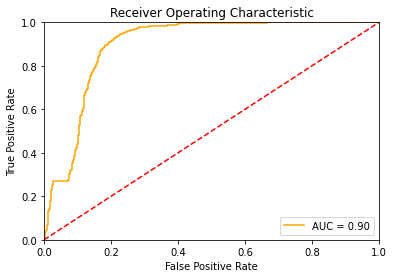

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba.reshape(-1))
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'orange', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from keras.models import load_model

model1.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
# model_new = load_model('my_model.h5')

In [ ]:
#@markdown model evaluation using k-fold cross validation

In [ ]:
false_ids = shuffle(false_ids, random_state=0)
part1_ids=false_ids[:6]
part2_ids=false_ids[6:13]
part3_ids=false_ids[13:]
true_ids = shuffle(true_ids,random_state=0)
part1_ids = part1_ids + true_ids[:4]
part2_ids = part2_ids+true_ids[4:8]
part3_ids=part3_ids + true_ids[8:]
df1=df[df['flight_code'].isin(part1_ids)]
df2=df[df['flight_code'].isin(part2_ids)]
df3=df[df['flight_code'].isin(part3_ids)]

In [ ]:
df1.shape, df2.shape, df3.shape

((3556, 8), (3818, 8), (3063, 8))

In [ ]:
k=3
epochs=6
batch_size=32
test_acc=[]
recall=[]
precision=[]
fscore=[]
for data in  [df1, df2, df3]:
  test_data=data
  train_data=df[~df['flight_code'].isin(list(test_data['flight_code']))]
  X_train, y_train = input_creation(train_data)
  X_test, y_test = input_creation(test_data)
  X_train=data_augmentation(X_train)
  X_train=np.array(X_train)
  model1.fit(X_train, y_train,
              batch_size=batch_size,
             epochs=epochs)
  y_pred=model1.predict_classes(X_test)
  test_acc.append(accuracy_score(y_test, y_pred))
  recall.append(recall_score(y_test, y_pred))
  precision.append(precision_score(y_test, y_pred))
  fscore.append(f1_score(y_test, y_pred))
  evaluation_matrics(y_test, y_pred)


  

Epoch 1/6
216/216 [==============================] - 53s 245ms/step - loss: 0.3894 - accuracy: 0.8428
Epoch 2/6
216/216 [==============================] - 52s 241ms/step - loss: 0.3375 - accuracy: 0.8538
Epoch 3/6
216/216 [==============================] - 52s 241ms/step - loss: 0.2996 - accuracy: 0.8808
Epoch 4/6
216/216 [==============================] - 52s 241ms/step - loss: 0.2664 - accuracy: 0.9002
Epoch 5/6
216/216 [==============================] - 52s 241ms/step - loss: 0.2792 - accuracy: 0.8922
Epoch 6/6
216/216 [==============================] - 52s 241ms/step - loss: 0.2668 - accuracy: 0.8983


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'accuracy for False class': 0.5963345864661654}
{'accuracy for True class': 0.8445378151260504}
{'accuracy ': 0.6960067491563554}
Precision: 0.584019
Recall: 0.844538
F1 score: 0.690524
Epoch 1/6
207/207 [==============================] - 59s 286ms/step - loss: 0.4497 - accuracy: 0.7974
Epoch 2/6
207/207 [==============================] - 50s 242ms/step - loss: 0.4008 - accuracy: 0.8284
Epoch 3/6
207/207 [==============================] - 50s 242ms/step - loss: 0.3965 - accuracy: 0.8238
Epoch 4/6
207/207 [==============================] - 50s 242ms/step - loss: 0.3903 - accuracy: 0.8247
Epoch 5/6
207/207 [==============================] - 50s 242ms/step - loss: 0.3901 - accuracy: 0.8247
Epoch 6/6
207/207 [==============================] - 50s 242ms/step - loss: 0.3794 - accuracy: 0.8285
{'accuracy for False class': 0.9484667802385008}
{'accuracy for True class': 0.6870748299319728}
{'accuracy ': 0.8478260869565217}
Precision: 0.893015
Recall: 0.687075
F1 score: 0.776624
Epoch 1/6
231/

In [ ]:
#@markdown average value of evaluation metrics 

In [ ]:
np.mean(test_acc)

0.7555512000232607

In [ ]:
np.mean(recall)

0.6260844487097014

In [ ]:
np.mean(precision)

0.7145670226909268

In [ ]:
np.mean(fscore)

0.6410887177837622

In [2]:
#@markdown Second approach

In [ ]:
#@markdown split data into train/test sets, such that each set contains full images



In [ ]:
from sklearn.utils import shuffle
false_ids = list(set(df[df['class'] == False]['flight_code']))
false_ids = shuffle(false_ids, random_state=42)
train_ids=false_ids[:16]
test_ids=false_ids[16:]
true_ids = list(set(df[df['class'] == True]['flight_code']))
true_ids = shuffle(true_ids,random_state=42)
train_ids = train_ids + true_ids[:9]
test_ids=test_ids + true_ids[9:]
train_data=df[df['flight_code'].isin(train_ids)]
test_data=df[df['flight_code'].isin(test_ids)]

In [ ]:
np.unique(train_data['flight_code'])

array(['1TJZT39WQ', '2HHWV1DD4', '3KR1212BR', '42T73AQE8', 'E83UE8JT4',
       'EB4KG2F6D', 'F98U2YA3K', 'FPG2L7UTK', 'GP3VC3W6C', 'GU8YLRNEP',
       'GWWIAV2VV', 'J926FMUHU', 'KQNQBAHEH', 'KR4TV4KAT', 'M1UED3JAF',
       'N9WCYFDNV', 'NRI4TEP79', 'P1VA9VFEP', 'Q9ALKK7XZ', 'UI4P3E22W',
       'VQY9V2E1Q', 'VWYBY2FQY', 'W7AADUXTW', 'ZVDH6FY93', 'ZVFAN11AI'],
      dtype=object)

In [ ]:
np.unique(test_data['flight_code'])

array(['EVTQTDFEJ', 'FVI8IQG1F', 'FYXD9U983', 'N7W26YIGK', 'YLTE7FRJW'],
      dtype=object)

In [ ]:
print({'train_data' : len(train_data),  
       'test_data' : len(test_data)})

{'train_data': 8802, 'test_data': 1635}


In [ ]:
print({'train_classes' : train_data['class'].mean()})
print({'test_classes' : test_data['class'].mean()})

{'train_classes': 0.36877982276755283}
{'test_classes': 0.41529051987767585}


In [ ]:
##balanced training set
train_data1=train_data[train_data['class']==True] 
train_data2=train_data[train_data['class']==False].iloc[:train_data1.shape[0],:]
train_data=pd.concat((train_data1, train_data2))

In [ ]:
train_data.shape

(6492, 7)

In [ ]:
#@markdown get images and labels

In [ ]:
X_train, y_train = input_creation(train_data)
X_test, y_test = input_creation(test_data)

In [ ]:
X_train.shape

(6492, 224, 224, 3)

In [ ]:
#@markdown using vgg16 pretrained model for feature extraction 

In [ ]:
from keras.applications import vgg16
VGG_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling='max')

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#@markdown  get new features set: (6492, 512)

In [ ]:
feature_ectractor=VGG_model.predict(X_train)
# features=feature_ectractor.reshape(feature_ectractor.shape[0], -1)

In [ ]:
feature_ectractor.shape

(6492, 512)

In [ ]:
feature_ectractor.max(), feature_ectractor.min()

(225.897, 0.0)

In [ ]:
#@markdown feature preprocessin: log transformation and standard scaling

In [ ]:
features=np.where(feature_ectractor==0,  0.0001, feature_ectractor)
features.min(), features.max()

(1.1771917e-06, 225.897)

In [ ]:
features=np.log(features)

In [ ]:
features.max(), features.min()

(5.420079, -13.652379)

In [ ]:
from sklearn.preprocessing import StandardScaler
# define scaler
scaler = StandardScaler()
# fit and transform data
scaler.fit(features)
Xtrain=scaler.transform(features)


In [ ]:
Xtrain.min(), Xtrain.max()

(-20.497831, 21.849575)

In [ ]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [ ]:
#@markdown XGBoost Classifier: hyperparameters tuning

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
xgb = XGBClassifier(learning_rate=0.01, n_estimators=600)
param_comb = 10


random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc',  cv=3, verbose=3, random_state=1001)

random_search.fit(Xtrain, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.725, total=  43.1s
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.1s remaining:    0.0s


[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.811, total=  42.7s
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.992, total=  43.5s
[CV] subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8, score=0.719, total=  59.5s
[CV] subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8, score=0.810, total=  59.8s
[CV] subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8, score=0.995, total= 1.0min
[CV] subsample=0.8, min_child_weight=5, max_depth=5, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.8, min_child_weight=5, max_depth=5, gamma=1, colsample_bytree=0.8, score=0.719, total=  53.1s
[CV] subsample=0.8, min_child_weight=5, max_depth=5, gamma=1, colsample_bytree=0.8 
[CV]  su

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 22.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.01, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=600,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, s...ht=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated'

In [ ]:
random_search.best_params_

{'colsample_bytree': 0.8,
 'gamma': 2,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 0.8}

In [ ]:
xgb = XGBClassifier(learning_rate=0.01, n_estimators=600, min_child_weight=1, max_depth=3, gamma=2, colsample_bytree=0.8, subsample=0.8)

In [ ]:
# xgb = XGBClassifier(learning_rate=0.01, n_estimators=600, min_child_weight=1, max_depth=5, gamma=0.5, colsample_bytree=0.6, subsample=0.8)

In [ ]:
xgb.fit(Xtrain, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=2,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [ ]:
feature_ectractor_test=VGG_model.predict(X_test)
# features_test=feature_ectractor_test.reshape(feature_ectractor_test.shape[0], -1)
features_test=np.where(feature_ectractor_test==0,  0.0001, feature_ectractor_test)
features_test=np.log(features_test)
Xtest=scaler.transform(features_test)

In [ ]:
Xtest.min(), Xtest.max()

(-15.397625, 21.083878)

In [ ]:
#@markdown model evaluation: testing set

In [ ]:
y_pred=xgb.predict(Xtest)
y_pred_train=xgb.predict(Xtrain)

In [ ]:
print({"train accuracy" : accuracy_score(y_train, y_pred_train)})
print({'test accuracy': accuracy_score(y_test, y_pred)})


{'train accuracy': 0.9819778188539742}
{'test accuracy': 0.944954128440367}


In [ ]:
y_pred_proba=xgb.predict_proba(Xtest).T[1]

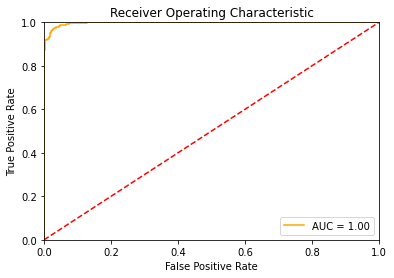

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'orange', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
def optimal_treshold(y_test, y_pred_proba):
  acc=0
  treshold=0
  for i in range(1, 100, 1):
    y_pred=np.where(y_pred_proba > i/100, 1, 0)
    score=accuracy_score(y_test, y_pred)
    if score > acc:
      acc=score
      treshold=i/100
      
  return treshold, acc


In [ ]:
treshold, acc = optimal_treshold(y_test, y_pred_proba)

In [ ]:
y_pred_new=np.where(y_pred_proba > treshold, 1, 0)
accuracy_score(y_test, y_pred_new)

0.9712538226299694

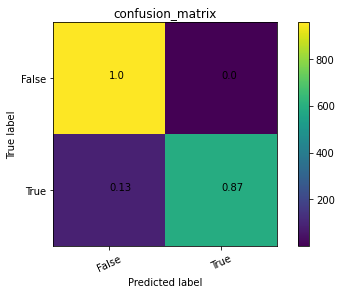

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
cm_class=['False', "True"]
plot_conf_matrix(cm, cm_class, normalize=True)

In [ ]:
evaluation_matrics(y_test, y_pred)

{'accuracy for False class': 0.9989539748953975}
{'accuracy for True class': 0.8689248895434463}
{'accuracy ': 0.944954128440367}
Precision: 0.998308
Recall: 0.868925
F1 score: 0.929134


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.91      1.00      0.95       956
        True       1.00      0.87      0.93       679

    accuracy                           0.94      1635
   macro avg       0.96      0.93      0.94      1635
weighted avg       0.95      0.94      0.94      1635



In [ ]:
#@markdown cross validation

In [ ]:
false_ids = shuffle(false_ids, random_state=0)
part1_ids=false_ids[:6]
part2_ids=false_ids[6:13]
part3_ids=false_ids[13:]
true_ids = shuffle(true_ids,random_state=0)
part1_ids = part1_ids + true_ids[:4]
part2_ids = part2_ids+true_ids[4:8]
part3_ids=part3_ids + true_ids[8:]
df1=df[df['flight_code'].isin(part1_ids)]
df2=df[df['flight_code'].isin(part2_ids)]
df3=df[df['flight_code'].isin(part3_ids)]

In [ ]:
df1.shape, df2.shape, df3.shape

((3331, 7), (3984, 7), (3122, 7))

In [ ]:
df1['class'].mean(), df2['class'].mean(), df3['class'].mean()

(0.41278895226658663, 0.35843373493975905, 0.35938500960922487)

In [ ]:
k=3
test_acc=[]
recall=[]
precision=[]
fscore=[]
for data in  [df1, df2, df3]:
  test_data=data
  train_data=df[~df['flight_code'].isin(list(test_data['flight_code']))]
  X_train, y_train = input_creation(train_data)
  X_test, y_test = input_creation(test_data)
  train_features=VGG_model.predict(X_train)
  features=np.where(train_features==0,  0.0001, train_features)
  features=np.log(features)
  scaler = StandardScaler()
  scaler.fit(features)
  Xtrain=scaler.transform(features)
  test_features=VGG_model.predict(X_test)
  features_test=np.where(test_features==0,  0.0001, test_features)
  features_test=np.log(features_test)
  Xtest=scaler.transform(features_test)
  xgb = XGBClassifier(learning_rate=0.01, n_estimators=600, min_child_weight=1, max_depth=3, gamma=2, colsample_bytree=0.8, subsample=0.8)
  xgb.fit(Xtrain, y_train)
  y_pred=xgb.predict(Xtest)
  test_acc.append(accuracy_score(y_test, y_pred))
  recall.append(recall_score(y_test, y_pred))
  precision.append(precision_score(y_test, y_pred))
  fscore.append(f1_score(y_test, y_pred))
  

In [ ]:
#@markdown average values of evaluation metrics

In [ ]:
np.mean(test_acc)

0.8379997001898097

In [ ]:
np.mean(recall)

0.8364396910279264

In [ ]:
np.mean(precision)

0.8144466613157914

In [ ]:
np.mean(fscore)

0.808602724759651